In [46]:
import os
import numpy as np

import torch

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_palette("Dark2", n_colors=8)

from source.constants import RESULTS_PATH, PLOTS_PATH
from source.utils.uncertainty_measures import calculate_uncertainties

os.makedirs(PLOTS_PATH, exist_ok=True)

In [47]:
seed = 42

methods = ["deep_ensemble", "laplace", "mc_dropout"]
dataset_names = ["cifar10", "cifar100", "svhn", "tin"]
adv_atks = ["fgsm", "linfpgd"] 
n_classes = [10, 100, 10, 200]
models = ["resnet18", "densenet169"]

method = methods[2]                         # select method 
adv_atk = adv_atks[1]                       # select adversarial attack

p_drop = 0.2                                # dropout rate of MC dropout     

model = models[0]                           # select model
runs = 5                                    # number of runs

print(adv_atk, method, model)

linfpgd mc_dropout resnet18


In [48]:
probits = list()
y_tests = list()

for dataset_name, n_class in zip(dataset_names, n_classes):

    if method == "deep_ensemble":
        path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_seed{seed}")
    elif method == "laplace":
        path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_seed{seed}_laplace")
    elif method == "mc_dropout":
        path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_dropout{p_drop}_seed{seed}")

    p = torch.load(os.path.join(path, f"{dataset_name}_probits.pt")).to(torch.float32)
    p = p.reshape(len(p), runs, -1, n_class)
    p = p[:, 0] # select first run
    y_test = torch.load(os.path.join(path, f"{dataset_name}_ys.pt"))
    y_tests.append(y_test)
    probits.append(p)
    print(probits[-1].shape)

uncertainties = list()

for d, ds_probits in enumerate(probits):
    # reversed_probits = torch.flip(ds_probits, [2])
    uncertainties.append(calculate_uncertainties(ds_probits, ds_probits))

### Adversarial examples

ae_probits = list()

for dataset_name, n_class in zip(dataset_names, n_classes):

    if method == "deep_ensemble":
        path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_seed{seed}")
    elif method == "laplace":
        path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_seed{seed}_laplace")
    elif method == "mc_dropout":
        path = os.path.join(RESULTS_PATH, f"{dataset_name}_{model}_dropout{p_drop}_seed{seed}")

    ae_path = os.path.join(path, "adversarial_examples")
    p = torch.load(os.path.join(ae_path, f"{adv_atk}_probits.pt")).to(torch.float32)
    p = p.reshape(len(p), runs, -1, n_class)
    p = p[:, 0] # select first run
    ae_probits.append(p)
    print(ae_probits[-1].shape)

ae_uncertainties = list()

for d, ds_probits in enumerate(ae_probits):
    # reversed_probits = torch.flip(ds_probits, [2])
    ae_uncertainties.append(calculate_uncertainties(ds_probits, ds_probits))

torch.Size([10000, 10, 10])
torch.Size([10000, 10, 100])
torch.Size([26032, 10, 10])
torch.Size([10000, 10, 200])
torch.Size([10000, 10, 10])
torch.Size([10000, 10, 100])
torch.Size([26032, 10, 10])
torch.Size([10000, 10, 200])


In [49]:
unc_names = ["A1", "A2", "A3", "B1", "B2", "B3", "C1", "C2", "C3"]
components = ["TU", "AU", "EU"]

verbose = False

scores_single = list()
scores_avg = list()

for i in range(len(dataset_names)):

    for agg in ("single", "average", "other"):
        
        # mask where clean predictions of attacked model are correct
        mask = torch.argmax(probits[i][:, 0], dim=-1) == y_tests[i]
        # mask where adversarial predictions of attacked model are incorrect
        mask_adv = torch.argmax(ae_probits[i][:, 0], dim=-1) != y_tests[i]
        # mask where clean predictions of attacked model are correct and adversarial predictions are incorrect
        mask = mask & mask_adv

        scores_clean = uncertainties[i]["A1"][1][mask] / np.log(n_classes[i])
        scores_adv = ae_uncertainties[i]["A1"][1][mask] / np.log(n_classes[i])

        scores_single.append(torch.stack([scores_clean, scores_adv]))

        scores_clean = uncertainties[i]["B2"][1][mask] / np.log(n_classes[i])
        scores_adv = ae_uncertainties[i]["B2"][1][mask] / np.log(n_classes[i])

        scores_avg.append(torch.stack([scores_clean, scores_adv]))

Dataset: CIFAR10


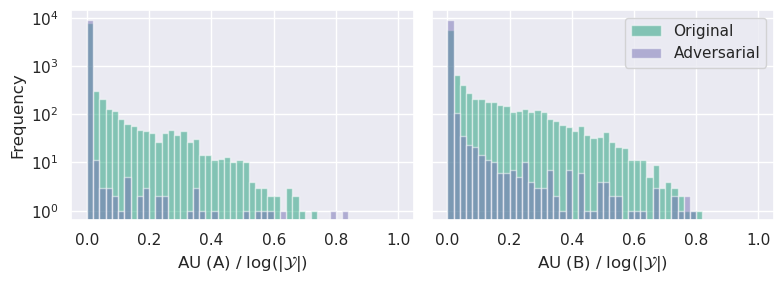

Dataset: CIFAR100


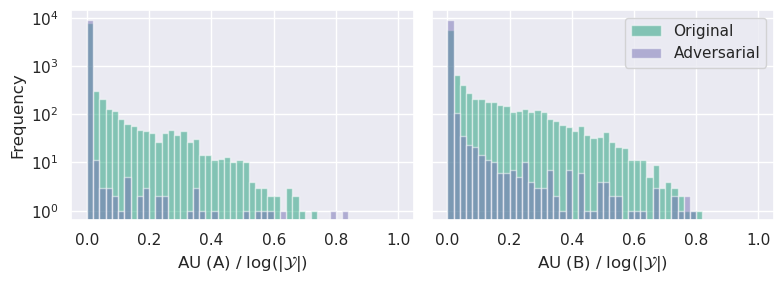

Dataset: SVHN


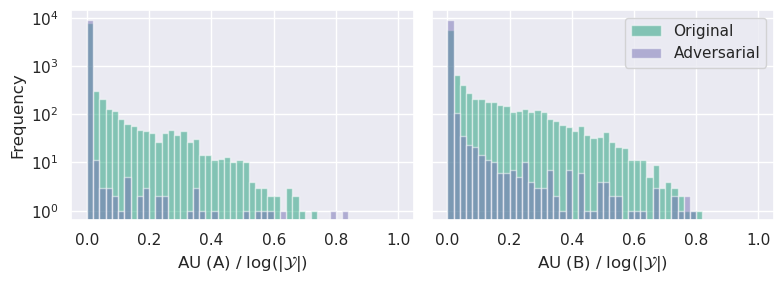

Dataset: TIN


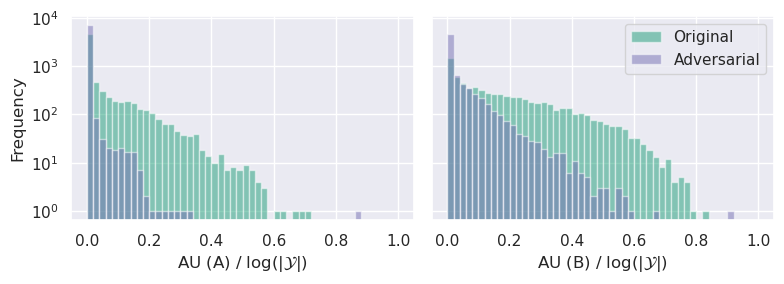

In [50]:
for d in range(len(dataset_names)):

    print(f"Dataset: {dataset_names[d].upper()}")

    f, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

    bins = torch.linspace(0, 1, 51).numpy()
    axs[0].hist(scores_single[d][0].numpy(), bins=bins, alpha=0.5, color="C0", label="Original", rasterized=True)
    axs[0].hist(scores_single[d][1].numpy(), bins=bins, alpha=0.5, color="C2", label="Adversarial", rasterized=True)
    axs[0].set_xlabel(r"AU (A) $/ \; \log(|\mathcal{Y}|)$")
    axs[0].set_yscale("log")
    axs[0].set_ylabel("Frequency")

    axs[1].hist(scores_avg[d][0].numpy(), bins=bins, alpha=0.5, color="C0", label="Original", rasterized=True)
    axs[1].hist(scores_avg[d][1].numpy(), bins=bins, alpha=0.5, color="C2", label="Adversarial", rasterized=True)
    axs[1].legend()
    axs[1].set_yscale("log")
    axs[1].set_xlabel(r"AU (B) $/ \; \log(|\mathcal{Y}|)$")

    f.tight_layout()
    f.savefig(os.path.join(PLOTS_PATH, f"ae_hist_{adv_atk}_{method}_{dataset_names[d]}_{model}.pdf"))
    plt.show()